In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import patches

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster import hierarchy

In [2]:
data = pd.read_csv("../../clustering.csv", header = None)
data.head()

,0,1
0,41.788907,52.220182
1,-96.586516,90.957033
2,-54.143591,-99.153377
3,19.929231,-45.859779
4,-82.941076,84.099186


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       400 non-null    float64
 1   1       400 non-null    float64
dtypes: float64(2)
memory usage: 6.4 KB


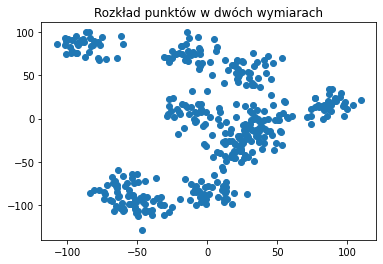

In [4]:
plt.scatter(data.iloc[:,0], data.iloc[:,1])
plt.title('Rozkład punktów w dwóch wymiarach')
plt.show()

Jak widać, skupiska w danych nie są wyraźnie rozdzielone. Sprawdzimy jak z tym problemem poradzą sobie algorytmy klasteryzujące.

# Metoda k-średnich
Wśród prezentowanych w trakcie laboratorium metod, metoda k-średnich cechowała się wysoką skutecznością działania. Sprawdźmy jak poradzi sobie z tym zbiorem danych dla określonej liczby klastrów
## Wybór liczby klastrów metodą Silhouette oraz z pomocą indeksu Daviesa-Bouldina

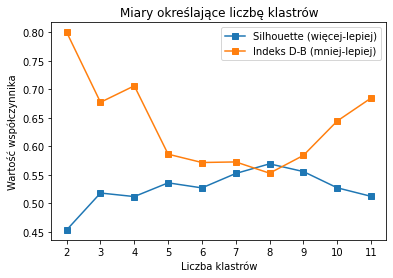

In [5]:
n_of_clusters = range(2, 12)
score = [[] for _ in range(2)]
for k in n_of_clusters:
    KMeans_model = KMeans(n_clusters = k, random_state = 114)
    labels = KMeans_model.fit_predict(data)
    score[0].append(silhouette_score(data, labels))
    score[1].append(davies_bouldin_score(data, labels))
plt.plot(n_of_clusters, score[0], 's-', n_of_clusters, score[1], 's-')
plt.ylabel('Wartość współczynnika')
plt.xlabel('Liczba klastrów')
plt.legend(('Silhouette (więcej-lepiej)', 'Indeks D-B (mniej-lepiej)'))
plt.title('Miary określające liczbę klastrów')
plt.xticks(n_of_clusters)
plt.show()


Zarówno metoda Silhouette jak i indeks Daviesa-Bouldina wykazały, że optymalną liczbą klastrów jest 8.<br>
Sprawdźmy w jaki sposób algorytm k-średnich poradził sobie z ośmioma klastrami.


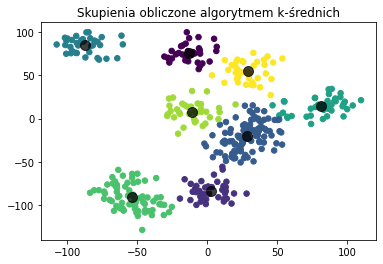

In [6]:
def model_scatter(data, model, n_clusters):
    Model = model(n_clusters=n_clusters)
    labels = Model.fit_predict(data)
    return plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=labels, s=30, cmap='viridis'), Model
scatter, KMeansModel = model_scatter(data, KMeans, 8)
scatter
centers = KMeansModel.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.75)
plt.title('Skupienia obliczone algorytmem k-średnich')
plt.show()



Algorytm k-średnich całkiem sprawnie poradził sobie z problemem podziału na 8 klastrów. Jedyne, subiektywne, uwagi można mieć wokół klastra niebieskiego, gdzie wystąpiło też największe zagęszczenie punktów.

# Algorytm hierarchiczny - `AgglomerativeClustering()`
Dla powyższego algorytmu liczbę skupień wyznaczymy nieco bardziej arbitralnie.

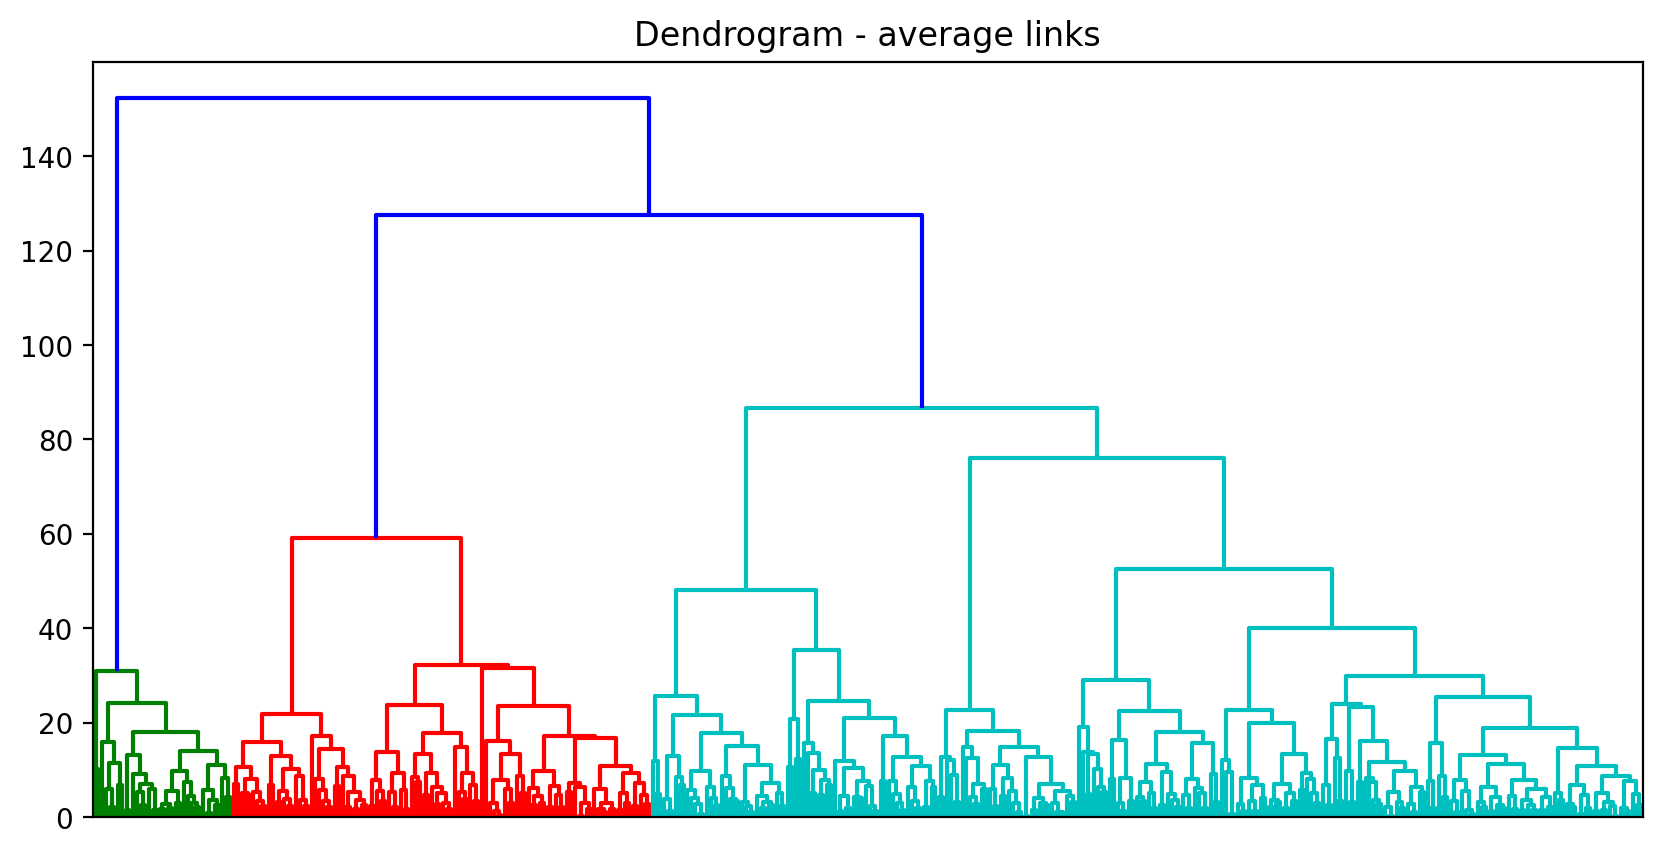

In [7]:
def dendrogram_plot(data, method):
    Z = hierarchy.linkage(data, method=method)
    plt.figure(figsize=(10, 5), dpi= 200, facecolor='w', edgecolor='k')
    hierarchy.dendrogram(Z)
    plt.xticks(ticks = [])
    #plt.yticks(ticks = range(0, 1600, 100))
    plt.title(f'Dendrogram - {method} links')
    plt.show()
dendrogram_plot(data, 'average')

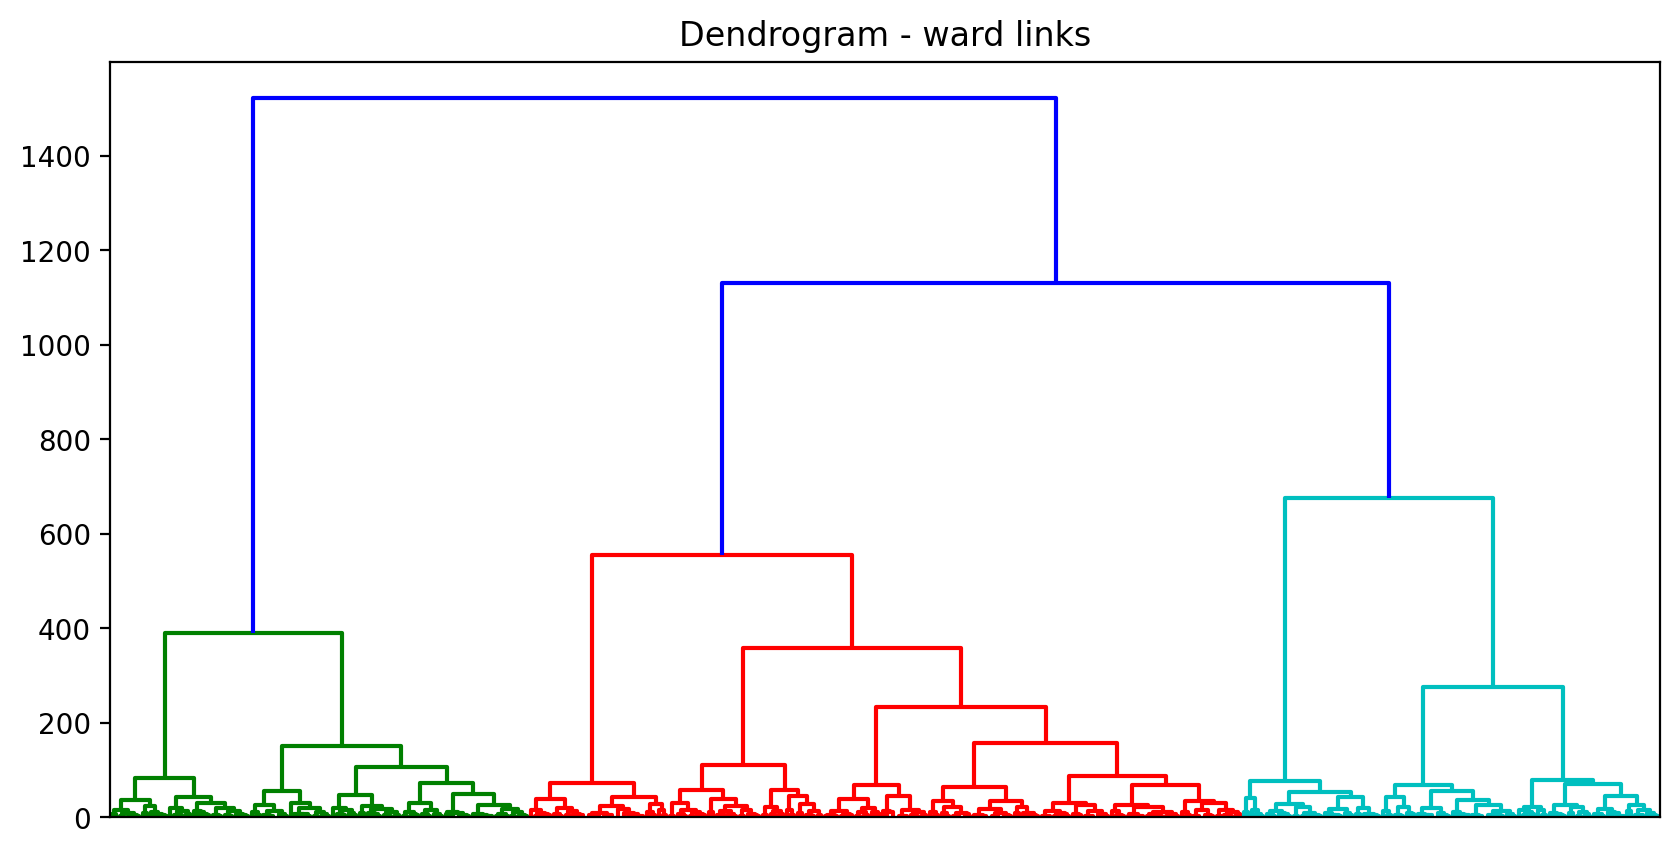

In [8]:
dendrogram_plot(data, 'ward')

Na podstawie powyższych grafik spróbujemy utworzyć dwa modele klasteryzujące:
* pierwszy z nich nie będzie miał z góry narzuconej liczby klas, jednak podamy maksymalną odległość pomiędzy punktami jednej klasy.
* drugi - będzie próbą zminimalizowania wariancji wśród obserwacji w jednym klastrze - przy użyciu indeksu Calinskiego-Harabasza (pomysł: https://www.stat.cmu.edu/~ryantibs/datamining/lectures/06-clus3.pdf)

## Pierwszy sposób - maksymalna odległość w klastrze 
Ustalmy maksymalną odległość między obserwacjami w klastrze jako 50 przy metodzie połączeń średnich

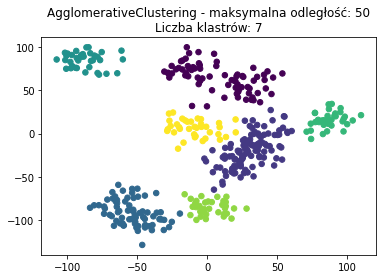

In [9]:
dist_model = AgglomerativeClustering(n_clusters=None, linkage='average', distance_threshold=50)
labels = dist_model.fit_predict(data)
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=labels, s=30, cmap='viridis')
plt.title(f'AgglomerativeClustering - maksymalna odległość: {dist_model.distance_threshold}\n' +
         f'Liczba klastrów: {dist_model.n_clusters_}')
plt.show()

## Drugi sposób - Calinski-Harabasz index

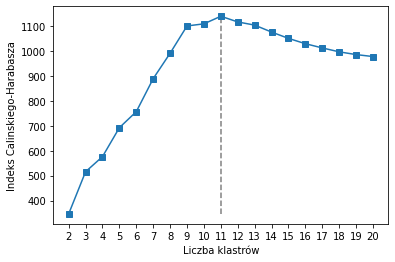

In [10]:
n_of_clusters = range(2, 21)
score = []
for k in n_of_clusters:
    CHmodel = AgglomerativeClustering(n_clusters = k)
    labels = CHmodel.fit_predict(data)
    score.append(calinski_harabasz_score(data, labels))
plt.plot(n_of_clusters, score, 's-' )
plt.ylabel('Indeks Calinskiego-Harabasza')
plt.xlabel('Liczba klastrów')
plt.vlines(n_of_clusters[np.argmax(score)], min(score), max(score), linestyles = '--', alpha = 0.5)
plt.xticks(n_of_clusters)
plt.show()

Tym razem optymalna liczba klastrów została ustalona na 11 - więcej niż przy użyciu wcześniejszych metod.

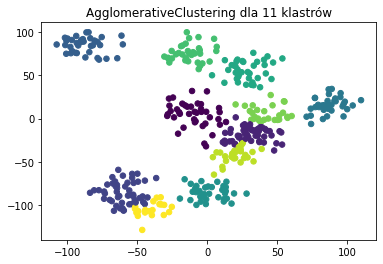

In [11]:
scatter, AgglomerativeModel = model_scatter(data, AgglomerativeClustering, 11)
scatter
plt.title('AgglomerativeClustering dla 11 klastrów')
plt.show()

# Podsumowanie
Metoda `AgglomerativeClustering()` ma sporą zaletę w postaci różnorodności określenia liczby skupień w zadaniu klasteryzacji. W trakcie testów skorzystaliśmy z obu sposobów: ustalenie maksymalnej odległości między punktami na 50 oraz liczby klastrów na 11. W mojej, subiektywnej opinii, podział obserwacji na 11 grup jest zbyt granularny - lepiej spisały się algorytmy grupujące na 7-8 skupień. Ponadto, można zauważyć, że algorytmy różnie dzieliły punkty znajdujące się w największym zagęszczeniu. W mojej opinii lepiej poradził sobie algorytm k średnich, który nieźle podzielił punkty w zagęszczonych obszarach, jak i podjął dobrą decyzję o rozdzieleniu skupienia w górnej części wykresu na dwa klastry.